<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/v2.0/notebooks/optuna.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/optuna.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Load optuna library

In [1]:
import numpy as np
import pandas as pd
import os, sys 
import optuna

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12597679.svg)](https://doi.org/10.5281/zenodo.12597679)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [2]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_BIO.csv", index_col=0)
X_n2v = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_EmbN2V_128.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})
print(df_y.value_counts(normalize=False))
consts = X_bio.columns[X_bio.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_bio = X_bio.drop(consts, axis=1)
X_bio = pd.DataFrame(StandardScaler().fit_transform(X_bio), index=X_bio.index, columns=X_bio.columns)
X_cccfs = pd.DataFrame(StandardScaler().fit_transform(X_cccfs), index=X_cccfs.index, columns=X_cccfs.columns)
consts = X_cccfs.columns[X_cccfs.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_cccfs = X_cccfs.drop(consts, axis=1)
X_cccfs = pd.DataFrame(StandardScaler().fit_transform(X_cccfs), index=X_cccfs.index, columns=X_cccfs.columns)
df_X = pd.merge(X_bio, X_n2v, left_index=True, right_index=True, how='outer')
df_X = pd.merge(df_X, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X,df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Tune model (Optuna)
Start tuning session

In [12]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import annotations
from icarlearn.ensemble.splitvotingens import *
from sklearn.metrics import *
from imblearn.metrics import geometric_mean_score
from optuna import Trial
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective_cv(trial : Trial, X : pd.DataFrame, y : np.ndarray | pd.Series, random_state : int=42):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'n_voters': trial.suggest_int('n_voters', 1, 20, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 60, 200, step=20),
    }
    gbm = sveLGBM(**params)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    my_scorer = make_scorer(balanced_accuracy_score)
    scores = cross_val_score(gbm, X, y, scoring=my_scorer, cv=kf)
    return np.mean(scores)

savepath = '../pycaret'
study = optuna.create_study(
    study_name=f'svelgbm_{tissue}',
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{savepath}/sveLGBM_{tissue}_ba_cv.db',
    sampler=optuna.samplers.TPESampler(seed = 10)
    )
study.optimize(lambda trial: objective_cv(trial, df_X, df_y), n_trials=50)
best_params = study.best_params
print('Best Params:', best_params)
df = study.trials_dataframe()
df.to_csv(os.path.join(f'sveLGBM_{tissue}_hypersearch_ba_cv.csv'))
df.sort_values('value', ascending=False)

[I 2024-07-05 10:40:05,258] A new study created in RDB with name: svelgbm_Kidney


LGBMClassifier(learning_rate=0.034885205571560766, n_estimators=160, verbose=-1)


[I 2024-07-05 10:42:10,561] Trial 0 finished with value: 0.7407717420457234 and parameters: {'learning_rate': 0.034885205571560766, 'n_voters': 1, 'n_estimators': 160}. Best is trial 0 with value: 0.7407717420457234.


LGBMClassifier(learning_rate=0.03144906695123094, n_estimators=80, verbose=-1)


[I 2024-07-05 10:43:11,432] Trial 1 finished with value: 0.8752110437467492 and parameters: {'learning_rate': 0.03144906695123094, 'n_voters': 10, 'n_estimators': 80}. Best is trial 1 with value: 0.8752110437467492.


LGBMClassifier(learning_rate=0.002489577954043502, n_estimators=80, verbose=-1)


[I 2024-07-05 10:44:18,238] Trial 2 finished with value: 0.7958859236236762 and parameters: {'learning_rate': 0.002489577954043502, 'n_voters': 16, 'n_estimators': 80}. Best is trial 1 with value: 0.8752110437467492.


LGBMClassifier(learning_rate=0.0015020335327164721, n_estimators=200,
               verbose=-1)


[I 2024-07-05 10:46:33,189] Trial 3 finished with value: 0.8462919777474476 and parameters: {'learning_rate': 0.0015020335327164721, 'n_voters': 14, 'n_estimators': 200}. Best is trial 1 with value: 0.8752110437467492.


LGBMClassifier(learning_rate=0.001018348745338606, n_estimators=180, verbose=-1)


[I 2024-07-05 10:48:31,311] Trial 4 finished with value: 0.8287753116019673 and parameters: {'learning_rate': 0.001018348745338606, 'n_voters': 11, 'n_estimators': 180}. Best is trial 1 with value: 0.8752110437467492.


LGBMClassifier(learning_rate=0.01679005557522366, verbose=-1)


[I 2024-07-05 10:49:47,148] Trial 5 finished with value: 0.8632172609975977 and parameters: {'learning_rate': 0.01679005557522366, 'n_voters': 15, 'n_estimators': 100}. Best is trial 1 with value: 0.8752110437467492.


LGBMClassifier(learning_rate=0.06847755494022188, n_estimators=140, verbose=-1)


[I 2024-07-05 10:51:38,328] Trial 6 finished with value: 0.8866857436072106 and parameters: {'learning_rate': 0.06847755494022188, 'n_voters': 15, 'n_estimators': 140}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.0019245982882901906, n_estimators=160,
               verbose=-1)


[I 2024-07-05 10:52:55,253] Trial 7 finished with value: 0.7153186056414298 and parameters: {'learning_rate': 0.0019245982882901906, 'n_voters': 8, 'n_estimators': 160}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.007650086554079969, n_estimators=140, verbose=-1)


[I 2024-07-05 10:54:32,861] Trial 8 finished with value: 0.862158741986349 and parameters: {'learning_rate': 0.007650086554079969, 'n_voters': 9, 'n_estimators': 140}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.010623716801588558, n_estimators=140, verbose=-1)


[I 2024-07-05 10:56:12,633] Trial 9 finished with value: 0.8640947965897656 and parameters: {'learning_rate': 0.010623716801588558, 'n_voters': 14, 'n_estimators': 140}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.07781750281810046, n_estimators=120, verbose=-1)


[I 2024-07-05 10:58:14,103] Trial 10 finished with value: 0.8797622264000727 and parameters: {'learning_rate': 0.07781750281810046, 'n_voters': 20, 'n_estimators': 120}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.0772423225940892, n_estimators=120, verbose=-1)


[I 2024-07-05 11:00:10,519] Trial 11 finished with value: 0.8787985668790969 and parameters: {'learning_rate': 0.0772423225940892, 'n_voters': 19, 'n_estimators': 120}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.09918273483363291, n_estimators=120, verbose=-1)


[I 2024-07-05 11:02:05,117] Trial 12 finished with value: 0.8830149700418474 and parameters: {'learning_rate': 0.09918273483363291, 'n_voters': 19, 'n_estimators': 120}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.09137003464214873, n_estimators=60, verbose=-1)


[I 2024-07-05 11:03:08,973] Trial 13 finished with value: 0.8784032335017505 and parameters: {'learning_rate': 0.09137003464214873, 'n_voters': 18, 'n_estimators': 60}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.03583312384979869, verbose=-1)


[I 2024-07-05 11:04:42,805] Trial 14 finished with value: 0.872713239585966 and parameters: {'learning_rate': 0.03583312384979869, 'n_voters': 17, 'n_estimators': 100}. Best is trial 6 with value: 0.8866857436072106.


LGBMClassifier(learning_rate=0.05337428233829393, n_estimators=160, verbose=-1)


[I 2024-07-05 11:06:33,670] Trial 15 finished with value: 0.8889583948789233 and parameters: {'learning_rate': 0.05337428233829393, 'n_voters': 12, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.04889478204637204, n_estimators=180, verbose=-1)


[I 2024-07-05 11:07:57,627] Trial 16 finished with value: 0.8734267161682332 and parameters: {'learning_rate': 0.04889478204637204, 'n_voters': 5, 'n_estimators': 180}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.01809283027271325, n_estimators=160, verbose=-1)


[I 2024-07-05 11:09:40,278] Trial 17 finished with value: 0.8754985227706765 and parameters: {'learning_rate': 0.01809283027271325, 'n_voters': 12, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.003822936881700532, n_estimators=200, verbose=-1)


[I 2024-07-05 11:11:03,594] Trial 18 finished with value: 0.7979277697357621 and parameters: {'learning_rate': 0.003822936881700532, 'n_voters': 6, 'n_estimators': 200}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.019788886529687046, n_estimators=180, verbose=-1)


[I 2024-07-05 11:13:02,330] Trial 19 finished with value: 0.876310897589158 and parameters: {'learning_rate': 0.019788886529687046, 'n_voters': 13, 'n_estimators': 180}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.05338262543312653, n_estimators=140, verbose=-1)


[I 2024-07-05 11:14:14,182] Trial 20 finished with value: 0.838152666677184 and parameters: {'learning_rate': 0.05338262543312653, 'n_voters': 3, 'n_estimators': 140}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.09481377789192426, n_estimators=120, verbose=-1)


[I 2024-07-05 11:16:10,170] Trial 21 finished with value: 0.8829946137887358 and parameters: {'learning_rate': 0.09481377789192426, 'n_voters': 17, 'n_estimators': 120}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.05414576727198354, verbose=-1)


[I 2024-07-05 11:17:49,082] Trial 22 finished with value: 0.8744059843153809 and parameters: {'learning_rate': 0.05414576727198354, 'n_voters': 20, 'n_estimators': 100}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.06219156367209863, n_estimators=160, verbose=-1)


[I 2024-07-05 11:19:54,202] Trial 23 finished with value: 0.8863973828275988 and parameters: {'learning_rate': 0.06219156367209863, 'n_voters': 16, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.02588717259517985, n_estimators=160, verbose=-1)


[I 2024-07-05 11:21:43,457] Trial 24 finished with value: 0.8829881183335843 and parameters: {'learning_rate': 0.02588717259517985, 'n_voters': 12, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.05463147045822757, n_estimators=140, verbose=-1)


[I 2024-07-05 11:23:25,547] Trial 25 finished with value: 0.8849742803355332 and parameters: {'learning_rate': 0.05463147045822757, 'n_voters': 15, 'n_estimators': 140}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.012374066848229457, n_estimators=180, verbose=-1)


[I 2024-07-05 11:25:20,879] Trial 26 finished with value: 0.8710090777401337 and parameters: {'learning_rate': 0.012374066848229457, 'n_voters': 13, 'n_estimators': 180}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.006765368115832032, n_estimators=160, verbose=-1)


[I 2024-07-05 11:27:16,721] Trial 27 finished with value: 0.8520297469516457 and parameters: {'learning_rate': 0.006765368115832032, 'n_voters': 16, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.024425992658766275, n_estimators=140, verbose=-1)


[I 2024-07-05 11:28:29,288] Trial 28 finished with value: 0.8769587670446098 and parameters: {'learning_rate': 0.024425992658766275, 'n_voters': 8, 'n_estimators': 140}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.04005483246148786, n_estimators=160, verbose=-1)


[I 2024-07-05 11:30:37,486] Trial 29 finished with value: 0.7452881377518729 and parameters: {'learning_rate': 0.04005483246148786, 'n_voters': 1, 'n_estimators': 160}. Best is trial 15 with value: 0.8889583948789233.


LGBMClassifier(learning_rate=0.060686849742406554, n_estimators=180, verbose=-1)


[I 2024-07-05 11:32:53,875] Trial 30 finished with value: 0.8906720807227014 and parameters: {'learning_rate': 0.060686849742406554, 'n_voters': 11, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.04230197260627401, n_estimators=180, verbose=-1)


[I 2024-07-05 11:35:07,258] Trial 31 finished with value: 0.8877606375624749 and parameters: {'learning_rate': 0.04230197260627401, 'n_voters': 11, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.03582898565125672, n_estimators=200, verbose=-1)


[I 2024-07-05 11:37:34,575] Trial 32 finished with value: 0.8873002859246448 and parameters: {'learning_rate': 0.03582898565125672, 'n_voters': 10, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.03205353851901959, n_estimators=200, verbose=-1)


[I 2024-07-05 11:39:59,701] Trial 33 finished with value: 0.8869299197180457 and parameters: {'learning_rate': 0.03205353851901959, 'n_voters': 10, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.03966885611922471, n_estimators=200, verbose=-1)


[I 2024-07-05 11:42:25,529] Trial 34 finished with value: 0.8879433669587122 and parameters: {'learning_rate': 0.03966885611922471, 'n_voters': 11, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.04319003673574107, n_estimators=180, verbose=-1)


[I 2024-07-05 11:44:32,249] Trial 35 finished with value: 0.8861758429189877 and parameters: {'learning_rate': 0.04319003673574107, 'n_voters': 11, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.022546368246927382, n_estimators=200, verbose=-1)


[I 2024-07-05 11:46:14,652] Trial 36 finished with value: 0.8791062961730178 and parameters: {'learning_rate': 0.022546368246927382, 'n_voters': 8, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.014167473453802133, n_estimators=180, verbose=-1)


[I 2024-07-05 11:48:13,919] Trial 37 finished with value: 0.8742825234290305 and parameters: {'learning_rate': 0.014167473453802133, 'n_voters': 12, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.030997198322814116, n_estimators=180, verbose=-1)


[I 2024-07-05 11:50:25,731] Trial 38 finished with value: 0.8840125533522413 and parameters: {'learning_rate': 0.030997198322814116, 'n_voters': 9, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.064204785089025, n_estimators=200, verbose=-1)


[I 2024-07-05 11:52:08,684] Trial 39 finished with value: 0.8807555286444033 and parameters: {'learning_rate': 0.064204785089025, 'n_voters': 6, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.004231898290341377, n_estimators=180, verbose=-1)


[I 2024-07-05 11:54:12,481] Trial 40 finished with value: 0.8576545877752901 and parameters: {'learning_rate': 0.004231898290341377, 'n_voters': 13, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.04180977870402725, n_estimators=200, verbose=-1)


[I 2024-07-05 11:56:37,170] Trial 41 finished with value: 0.887944966789887 and parameters: {'learning_rate': 0.04180977870402725, 'n_voters': 11, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.04392173887975251, n_estimators=200, verbose=-1)


[I 2024-07-05 11:59:02,764] Trial 42 finished with value: 0.8886544296596204 and parameters: {'learning_rate': 0.04392173887975251, 'n_voters': 11, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.0477622734400061, n_estimators=200, verbose=-1)


[I 2024-07-05 12:01:32,680] Trial 43 finished with value: 0.8880293760033815 and parameters: {'learning_rate': 0.0477622734400061, 'n_voters': 9, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.027731488340438242, n_estimators=200, verbose=-1)


[I 2024-07-05 12:03:55,896] Trial 44 finished with value: 0.88367189595708 and parameters: {'learning_rate': 0.027731488340438242, 'n_voters': 9, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.07677541229535133, n_estimators=200, verbose=-1)


[I 2024-07-05 12:05:43,523] Trial 45 finished with value: 0.8887374886798554 and parameters: {'learning_rate': 0.07677541229535133, 'n_voters': 7, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.08301580433065923, n_estimators=200, verbose=-1)


[I 2024-07-05 12:07:29,532] Trial 46 finished with value: 0.8895503791145497 and parameters: {'learning_rate': 0.08301580433065923, 'n_voters': 7, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.07600483471256364, n_estimators=180, verbose=-1)


[I 2024-07-05 12:09:01,722] Trial 47 finished with value: 0.8752929069805981 and parameters: {'learning_rate': 0.07600483471256364, 'n_voters': 5, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.07981194984556822, n_estimators=200, verbose=-1)


[I 2024-07-05 12:10:46,648] Trial 48 finished with value: 0.8884673890770719 and parameters: {'learning_rate': 0.07981194984556822, 'n_voters': 7, 'n_estimators': 200}. Best is trial 30 with value: 0.8906720807227014.


LGBMClassifier(learning_rate=0.0647695606031327, n_estimators=180, verbose=-1)


[I 2024-07-05 12:12:22,010] Trial 49 finished with value: 0.8878702440350585 and parameters: {'learning_rate': 0.0647695606031327, 'n_voters': 7, 'n_estimators': 180}. Best is trial 30 with value: 0.8906720807227014.


Best Params: {'learning_rate': 0.060686849742406554, 'n_voters': 11, 'n_estimators': 180}


,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_n_estimators,params_n_voters,state
30,30,0.890672,2024-07-05 11:30:37.490389,2024-07-05 11:32:53.869723,0 days 00:02:16.379334,0.060687,180,11,COMPLETE
46,46,0.889550,2024-07-05 12:05:43.527367,2024-07-05 12:07:29.527279,0 days 00:01:45.999912,0.083016,200,7,COMPLETE
15,15,0.888958,2024-07-05 11:04:42.809554,2024-07-05 11:06:33.665982,0 days 00:01:50.856428,0.053374,160,12,COMPLETE
45,45,0.888737,2024-07-05 12:03:55.900843,2024-07-05 12:05:43.518161,0 days 00:01:47.617318,0.076775,200,7,COMPLETE
42,42,0.888654,2024-07-05 11:56:37.174906,2024-07-05 11:59:02.760024,0 days 00:02:25.585118,0.043922,200,11,COMPLETE
48,48,0.888467,2024-07-05 12:09:01.726714,2024-07-05 12:10:46.643617,0 days 00:01:44.916903,0.079812,200,7,COMPLETE
43,43,0.888029,2024-07-05 11:59:02.769256,2024-07-05 12:01:32.673896,0 days 00:02:29.904640,0.047762,200,9,COMPLETE
41,41,0.887945,2024-07-05 11:54:12.485604,2024-07-05 11:56:37.165931,0 days 00:02:24.680327,0.041810,200,11,COMPLETE
34,34,0.887943,2024-07-05 11:39:59.706104,2024-07-05 11:42:25.524548,0 days 00:02:25.818444,0.039669,200,11,COMPLETE
49,49,0.887870,2024-07-05 12:10:46.652464,2024-07-05 12:12:22.003953,0 days 00:01:35.351489,0.064770,180,7,COMPLETE


In [11]:
st = optuna.load_study(study_name=f'svelgbm_{tissue}', storage=f'sqlite:///{savepath}/sveLGBM_{tissue}_ba_cv.db')
st.best_params

{'learning_rate': 0.08506493968980974, 'n_voters': 11, 'n_estimators': 200}

### 6. Test the best model

In [17]:
pd.read_csv(f'sveLGBM_{tissue}_hypersearch_gm_cv.csv').sort_values(by='value', ascending=False)

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_n_estimators,params_n_voters,state
48,48,48,0.891382,2024-07-04 10:33:34.745115,2024-07-04 10:35:23.864892,0 days 00:01:49.119777,0.091252,140,12,COMPLETE
21,21,21,0.890347,2024-07-04 09:52:06.079645,2024-07-04 09:53:42.493322,0 days 00:01:36.413677,0.071948,120,11,COMPLETE
31,31,31,0.890126,2024-07-04 10:09:14.113387,2024-07-04 10:10:47.074513,0 days 00:01:32.961126,0.098112,120,11,COMPLETE
41,41,41,0.889951,2024-07-04 10:23:49.941190,2024-07-04 10:25:12.368326,0 days 00:01:22.427136,0.078344,100,12,COMPLETE
43,43,43,0.889913,2024-07-04 10:26:36.490849,2024-07-04 10:28:20.455412,0 days 00:01:43.964563,0.079061,120,12,COMPLETE
11,11,11,0.889778,2024-07-04 09:35:44.698448,2024-07-04 09:37:20.207210,0 days 00:01:35.508762,0.083394,120,11,COMPLETE
15,15,15,0.889379,2024-07-04 09:41:36.462569,2024-07-04 09:43:40.617261,0 days 00:02:04.154692,0.061627,160,13,COMPLETE
44,44,44,0.889371,2024-07-04 10:28:20.464272,2024-07-04 10:30:02.390648,0 days 00:01:41.926376,0.083310,120,10,COMPLETE
32,32,32,0.889227,2024-07-04 10:10:47.083200,2024-07-04 10:12:04.431695,0 days 00:01:17.348495,0.076535,100,12,COMPLETE
10,10,10,0.889079,2024-07-04 09:34:09.387962,2024-07-04 09:35:44.688765,0 days 00:01:35.300803,0.097376,120,11,COMPLETE


LGBMClassifier(learning_rate=0.09849119540851549, n_estimators=160, verbose=-1)
Classification with sveLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.958±0.005
Accuracy,0.916±0.002
BA,0.890±0.009
Specificity,0.920±0.003
Sensitivity,0.859±0.019
G-mean,0.889±0.009
MCC,0.588±0.009


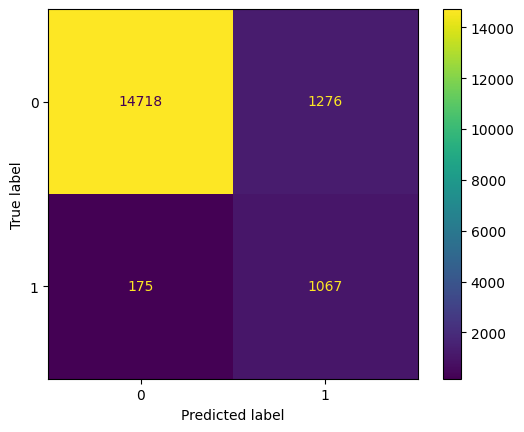

In [8]:
from icarlearn.ensemble.splitvotingens import sveLGBM
from icarlearn.validation.crossvalidate import skfold_cv
from imblearn.metrics import specificity_score, geometric_mean_score

from sklearn.metrics import *
myscorer = { 'ROC-AUC':      (roc_auc_score, {'multi_class':'ovr', 'average':'macro'}),
             'Accuracy'  :   (accuracy_score , {}),
             'BA'  :         (balanced_accuracy_score , {}),
             'Specificity' : (specificity_score, {'pos_label': 1}),
             'Sensitivity' : (recall_score   , {'pos_label': 1}),
            }
clf = sveLGBM(**study.best_params)
df_scores, scores, predictions = skfold_cv(df_X, df_y, clf, n_splits=5, seed=0, scorer=myscorer, show_progress=True, verbose=True)
df_scores

In [6]:
#df = pd.read_csv(f'velgbm_{tissue}_hypersearch_mcc_ba_2.csv').sort_values(['values_1', 'values_0'], ascending=[False, False]).rename(columns={'values_0': 'BA', 'values_1': 'MCC'})
df = pd.read_csv(f'svelgbm_Kidney_hypersearch_ba_cv.csv').sort_values('value', ascending=False).rename(columns={'value': 'BA'})
df.columns = df.columns.str.replace(r'params_', '')
selcolumns = ['boosting_type',	'learning_rate',	'n_estimators',	'n_voters', 'BA']
stds = df.std(numeric_only=True)
#df['BA+MCC'] = df.apply(lambda x: x.BA * stds.loc['BA'] + x.MCC * stds.loc['MCC'], axis=1)
#df['BA+MCC'] = df.apply(lambda x: x.BA  + x.MCC , axis=1)
print(df[selcolumns].sort_values('BA', ascending=False).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & boosting_type & learning_rate & n_estimators & n_voters & BA \\
\midrule
44 & gbdt & 0.098461 & 200 & 8 & 0.892022 \\
33 & gbdt & 0.081512 & 200 & 8 & 0.890714 \\
43 & gbdt & 0.049017 & 200 & 8 & 0.888816 \\
34 & gbdt & 0.079823 & 200 & 7 & 0.887190 \\
23 & gbdt & 0.065070 & 140 & 13 & 0.886479 \\
48 & gbdt & 0.045185 & 180 & 9 & 0.886413 \\
35 & gbdt & 0.076854 & 200 & 7 & 0.886389 \\
21 & gbdt & 0.050629 & 160 & 9 & 0.886107 \\
49 & gbdt & 0.057144 & 200 & 8 & 0.886095 \\
37 & gbdt & 0.077908 & 200 & 7 & 0.886046 \\
32 & gbdt & 0.034572 & 180 & 11 & 0.885119 \\
22 & gbdt & 0.039571 & 180 & 12 & 0.884895 \\
41 & gbdt & 0.051064 & 200 & 7 & 0.884837 \\
29 & gbdt & 0.030759 & 180 & 10 & 0.884531 \\
6 & gbdt & 0.065527 & 100 & 12 & 0.884275 \\
0 & gbdt & 0.031088 & 180 & 11 & 0.884031 \\
31 & gbdt & 0.031174 & 180 & 10 & 0.883759 \\
15 & gbdt & 0.041630 & 160 & 9 & 0.883406 \\
24 & gbdt & 0.040524 & 140 & 15 & 0.882707 \\
20 & gbdt & 0.099690 & 60 & 10